# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using LaTeXStrings
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem
includet("../mv_normal_gamma.jl"); using .mv_normal_gamma 
includet("../location_scale_tdist.jl"); using .location_scale_tdist

In [2]:
# Time
N = 50
fs = 10 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

# Planning horizon
T = 1;

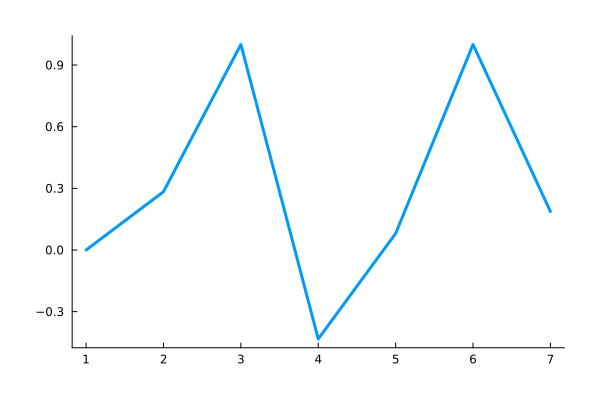

In [3]:
# Define system parameters
sys_mnoise_sd = 1e-1;
input_lims = (-1.,1.)

H = 2
sys_basis(x) = cat([1.0; [x.^d for d in 1:H]]...,dims=1)

M_in = 1
M_out = 1
M = size(sys_basis(zeros(M_out + 1 + M_in)),1);

df = digitalfilter(Lowpass(1.2; fs=fs), Butterworth(maximum([M_in, M_out])))
sys_coefficients = [0.0; sys_basis([coefb(df)[2:M_out+1]; coefa(df)[1:M_in+1]])[2:end]];

plot(sys_coefficients)

In [4]:
# Specify prior distributions
α0 = 1e2
β0 = 1e-1
μ0 = 1e-8ones(M)
Λ0 = 1e-1diagm(ones(M))
goals = [Normal(5.0, 1.0) for _ in 1:T]

1-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=5.0, σ=1.0)

## Parameter estimation: random

In [76]:
# Inputs
controls = clamp!(2randn(N).-1, input_lims...);

In [77]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

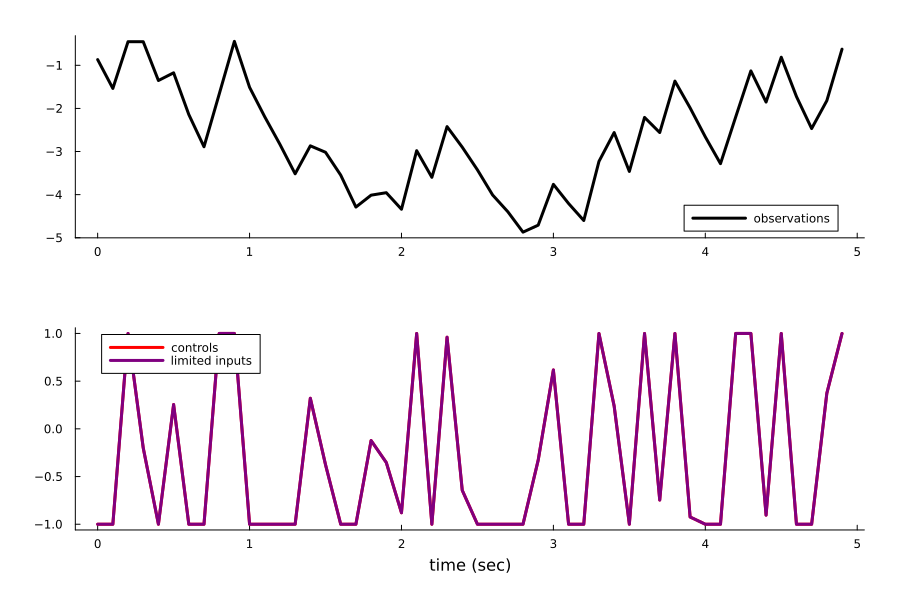

In [78]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [79]:
py_rnd = []
μ_rnd = [μ0]
Λ_rnd = [Λ0]
α_rnd = [α0]
β_rnd = [β0]
FE_rnd = []

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_rnd, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    
    push!(μ_rnd, agent.μ )
    push!(Λ_rnd, agent.Λ )
    push!(α_rnd, agent.α )
    push!(β_rnd, agent.β )

    push!(FE_rnd, agent.free_energy)
end

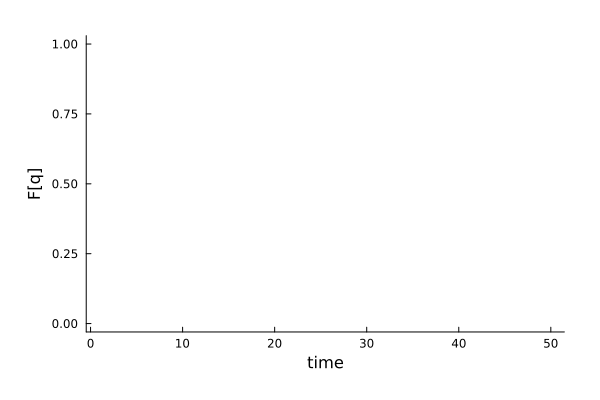

In [80]:
plot(FE_rnd, xlabel="time", ylabel="F[q]")

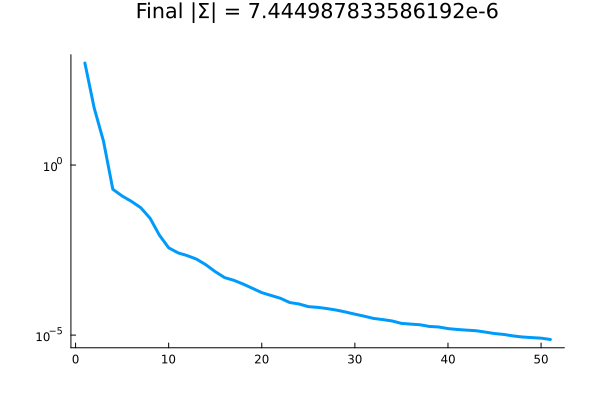

In [81]:
dSθ_rnd = det.(inv.(Λ_rnd))
final_dSθ_rnd = dSθ_rnd[end]
plot(dSθ_rnd, title="Final |Σ| = $final_dSθ_rnd", yscale=:log10)

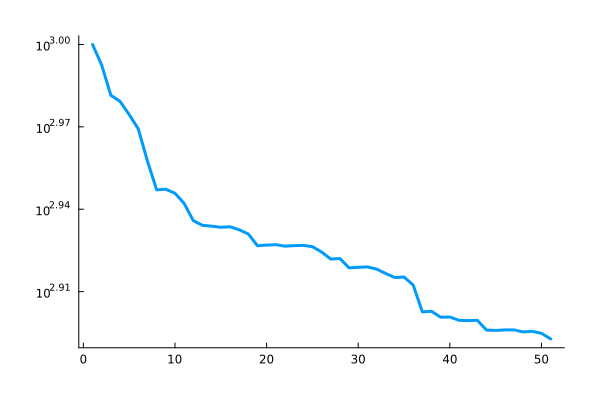

In [82]:
plot(α_rnd ./ β_rnd, yscale=:log10)

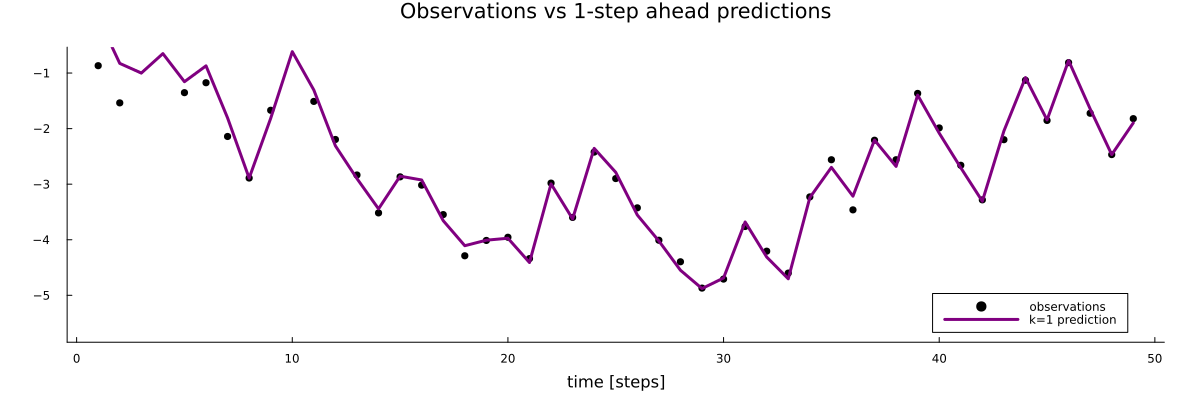

In [83]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 1

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end-1], color="black", label="observations")
plot!([py_rnd[k][1][K] for k in 1:(N-T)], ribbon=[py_rnd[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Parameter estimation: sinusoid control

In [84]:
# Inputs
Ω  = rand(5)*10
controls = mean([2sin.(ω.*tsteps) for ω in Ω]);

In [85]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

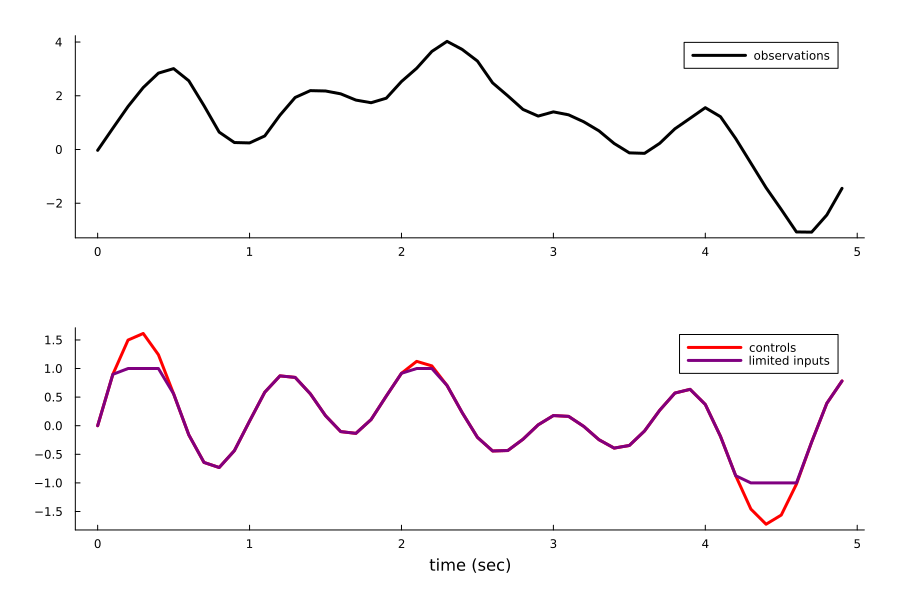

In [86]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [87]:
py_sin = []
μ_sin = [μ0]
Λ_sin = [Λ0]
α_sin = [α0]
β_sin = [β0]
FE_sin = []

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_sin, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    
    push!(μ_sin, agent.μ )
    push!(Λ_sin, agent.Λ )
    push!(α_sin, agent.α )
    push!(β_sin, agent.β )

    push!(FE_sin, agent.free_energy)
end

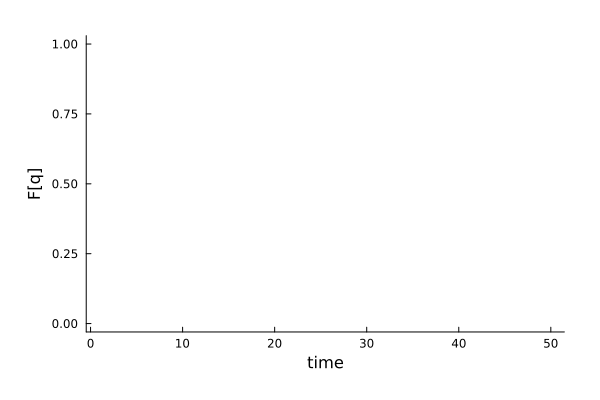

In [88]:
plot(FE_sin, xlabel="time", ylabel="F[q]")

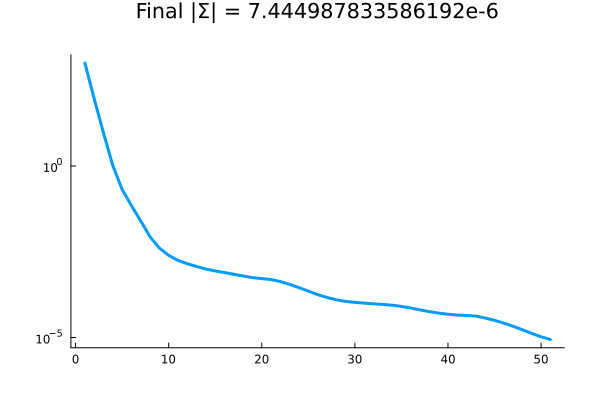

In [89]:
dSθ_sin = det.(inv.(Λ_sin))
final_dSθ_sin = dSθ_sin[end]
plot(dSθ_sin, title="Final |Σ| = $final_dSθ_rnd", yscale=:log10)

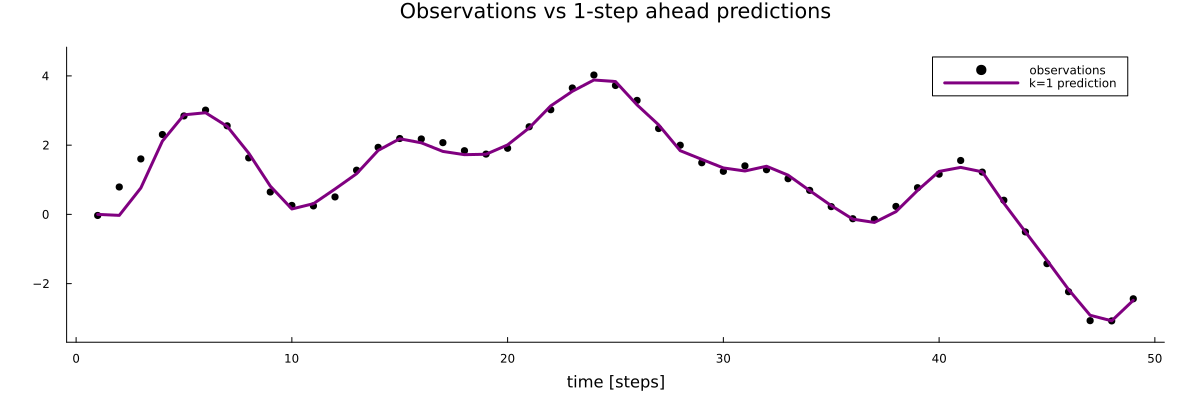

In [90]:
limsb = [minimum([-1.0, minimum(outputs)*1.2]), maximum(outputs)*1.2]
K = 1

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end-1], color="black", label="observations")
plot!([py_sin[k][1][K] for k in 1:(N-T)], ribbon=[py_sin[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Parameter estimation: EFE

In [91]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
py_EFE = []
FE_EFE = zeros(N)
MI_EFE = zeros(N,T)
CE_EFE = zeros(N,T)
Nu = 200
JMI_EFE = zeros(N,Nu)
JCE_EFE = zeros(N,Nu)
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = system.observation
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[k] = agent.free_energy
    push!( μ_EFE, agent.μ )
    push!( Λ_EFE, agent.Λ )
    push!( α_EFE, agent.α )
    push!( β_EFE, agent.β )
    
    # Optimal control
    policy = minimizeEFE(agent, goals, u_0=-1e-8*randn(T), time_limit=30., verbose=false, control_lims=input_lims)
    u_EFE[k+1:k+T] = policy

    MI_EFE[k,:]  = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_t) for u_t in policy]
    CE_EFE[k,:]  = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_t) for u_t in policy]
    JMI_EFE[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
    JCE_EFE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]

    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))

    # Act upon environment
    NARXsystem.update!(system, u_EFE[k+1])
    
end

Progress:   4%|█▋                                       |  ETA: 0:00:06

Progress:  42%|█████████████████▎                       |  ETA: 0:00:00

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [92]:
JCE_EFE

50×200 Matrix{Float64}:
 1.2506e-9    1.25059e-9   1.25058e-9   …  1.25059e-9   1.2506e-9
 1.6602e-9    1.65616e-9   1.65212e-9      9.56518e-10  9.53456e-10
 1.6116e-9    1.60816e-9   1.60471e-9      1.00125e-9   9.98538e-10
 1.26366e-9   1.25954e-9   1.25543e-9      5.79506e-10  5.76719e-10
 8.49338e-10  8.45771e-10  8.4221e-10      2.89421e-10  2.87341e-10
 1.37004e-9   1.36541e-9   1.36078e-9   …  6.05341e-10  6.02261e-10
 1.73633e-9   1.73124e-9   1.72616e-9      8.74397e-10  8.70787e-10
 2.17515e-9   2.16941e-9   2.16369e-9      1.18786e-9   1.18363e-9
 2.82535e-9   2.81859e-9   2.81184e-9      1.64505e-9   1.6399e-9
 3.32376e-9   3.31641e-9   3.30908e-9      2.02793e-9   2.0222e-9
 ⋮                                      ⋱               
 7.04431e-10  7.01063e-10  6.97703e-10     1.94989e-10  1.9322e-10
 1.07185e-9   1.06771e-9   1.06357e-9      4.07971e-10  4.05417e-10
 7.53674e-10  7.50197e-10  7.46729e-10     2.22084e-10  2.20199e-10
 5.54114e-10  5.51141e-10  5.48177e-10     

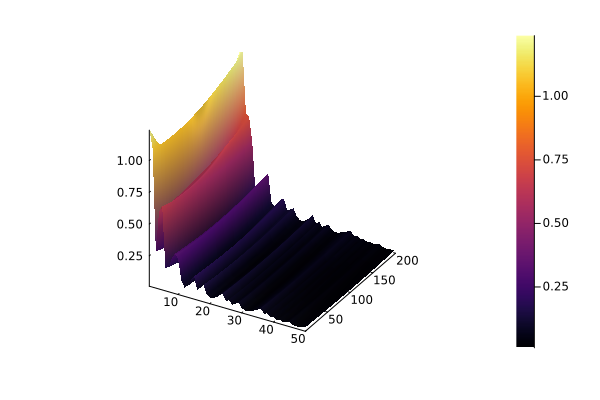

In [93]:
surface(JMI_EFE')

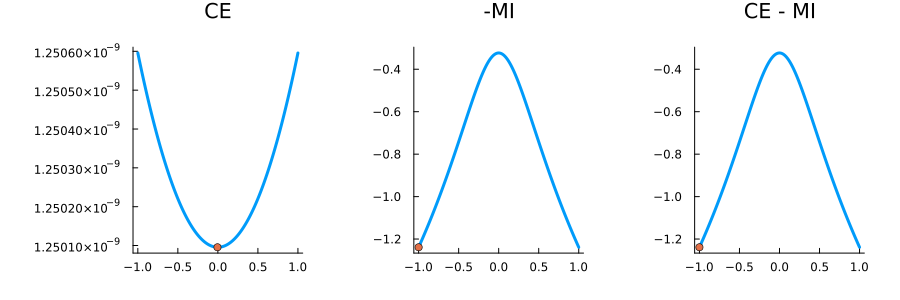

In [96]:
ix = 1

J0_EFE = JCE_EFE .- JMI_EFE

minJCE = argmin(JCE_EFE[ix,:])
minJMI = argmin(-JMI_EFE[ix,:])
minJ0  = argmin(J0_EFE[ix,:])

p441 = plot(urange, JCE_EFE[ix,:], title="CE")
scatter!([urange[minJCE]], [JCE_EFE[ix,minJCE]])
p442 = plot(urange, -JMI_EFE[ix,:], title="-MI")
scatter!([urange[minJMI]], [-JMI_EFE[ix,minJMI]])
p443 = plot(urange, J0_EFE[ix,:], title="CE - MI")
scatter!([urange[minJ0]], [J0_EFE[ix,minJ0]])

plot(p441, p442, p443, layout=(1,3), size=(900,300))

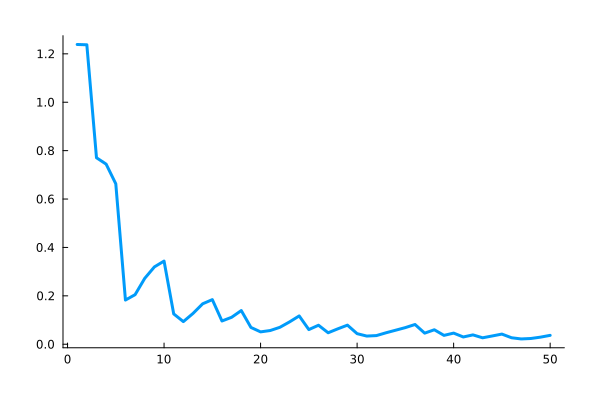

In [98]:
plot(MI_EFE)

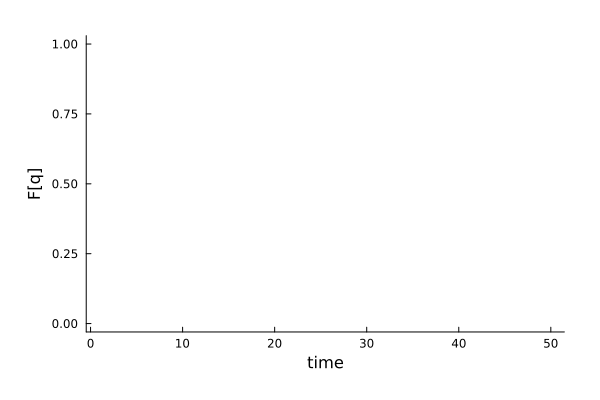

In [99]:
plot(FE_EFE, xlabel="time", ylabel="F[q]")

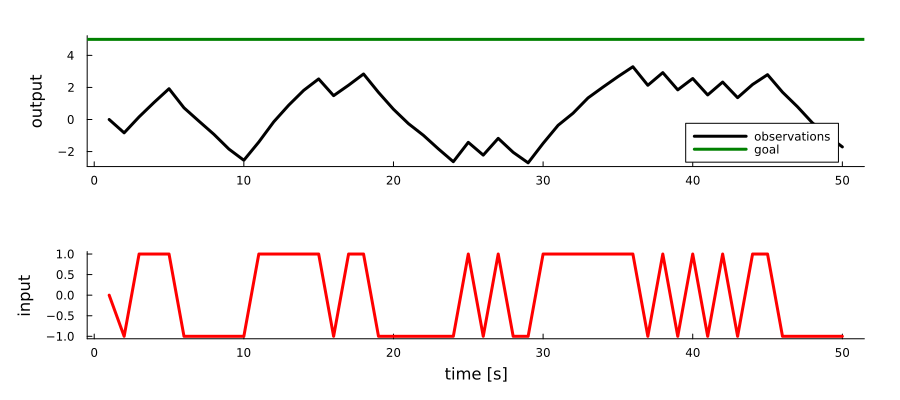

In [101]:
p1 = plot(y_EFE[1:end], color="black", label="observations", ylabel="output")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(u_EFE[1:end-T], color="red", ylabel="input", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.6, .4]), size=(900,400))

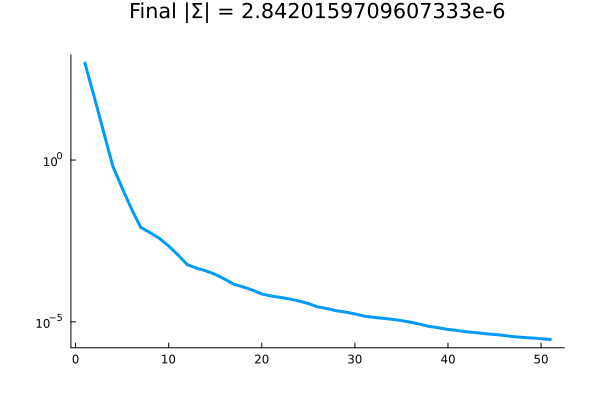

In [102]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/learningrates/figures/NARX-EFE-learningrate-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/learningrates/figures/NARX-EFE-learningrate-planning.gif")
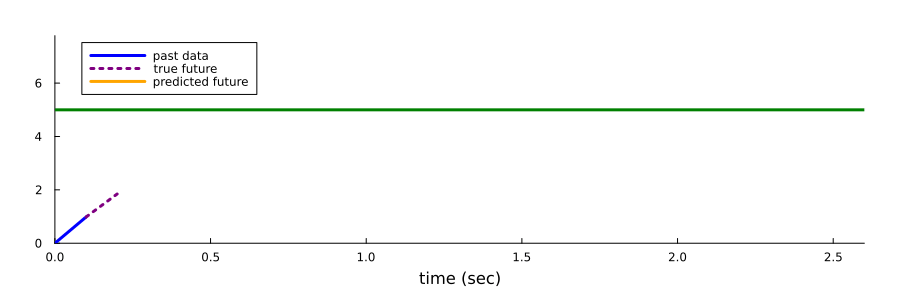

In [29]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-learningrate-planning.gif", fps=24)

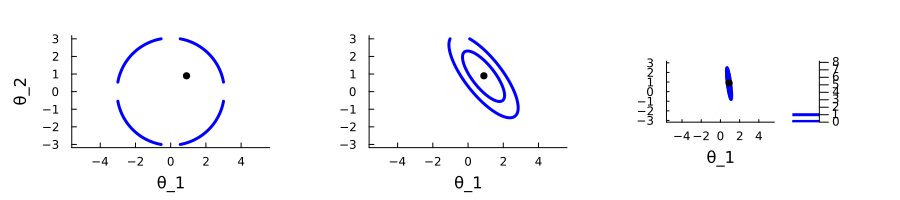

In [70]:
xr1 = range(-3, stop=3, length=100)
xr2 = range(-3, stop=3, length=100)

clevels = [0.01, 0.1, 1.0]

kix = 2
p441 = plot(ylabel="θ_2", xlabel="θ_1", aspect_ratio = 1)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", colorbar=false, levels=clevels)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

kix = 5
p442 = plot(ylabel="", xlabel="θ_1",aspect_ratio = 1)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", colorbar=false, levels=clevels)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

kix = 30
p443 = plot(ylabel="", xlabel="θ_1",aspect_ratio = 1)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", levels=clevels)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

plot(p441, p442, p443, layout=(1,3), size=(900,200))

## Parameter estimation: MSE

In [31]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
py_MSE = []
FE_MSE = zeros(N)
MI_MSE = zeros(N,T)
CE_MSE = zeros(N,T)
Nu = 200
JMI_MSE = zeros(N,Nu)
JCE_MSE = zeros(N,Nu)
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = system.observation
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )
    
    # Optimal control
    policy = minimizeMSE(agent, goals, u_0=1e-8randn(T), time_limit=10., control_lims=input_lims)
    u_MSE[k+1:k+T] = policy

    MI_MSE[k,:]  = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_t) for u_t in policy]
    CE_MSE[k,:]  = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_t) for u_t in policy]
    JMI_MSE[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
    JCE_MSE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]

    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))

    # Act upon environment
    NARXsystem.update!(system, u_MSE[k+1])
    
end

Progress:   4%|█▋                                       |  ETA: 0:00:42

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


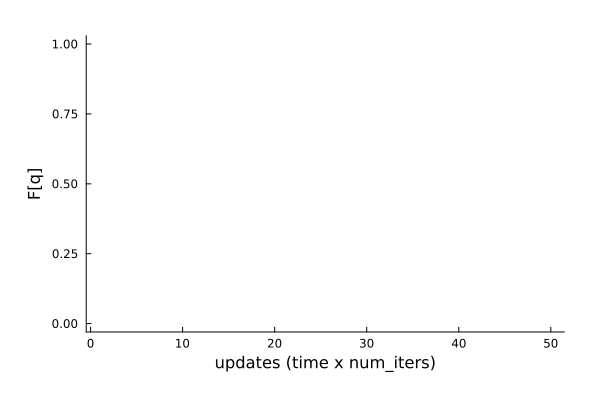

In [32]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

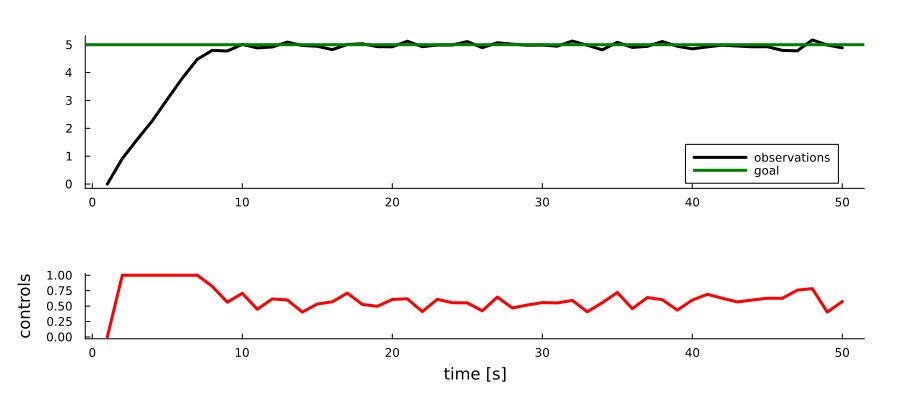

In [33]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(u_MSE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

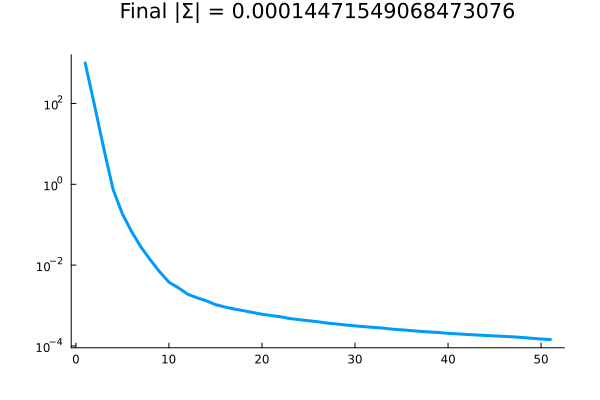

In [34]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/learningrates/figures/NARX-MSE-learningrate-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/learningrates/figures/NARX-MSE-learningrate-planning.gif")
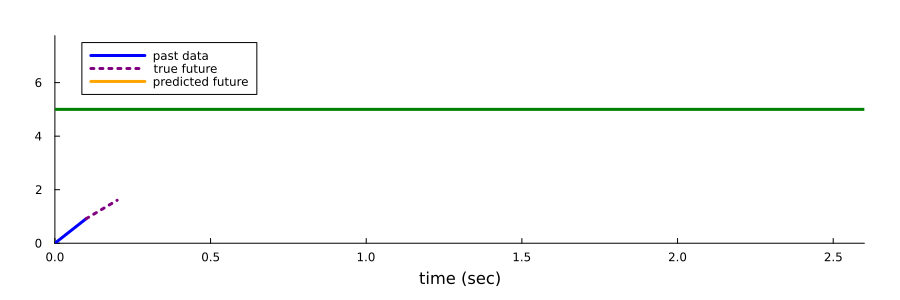

In [58]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-learningrate-planning.gif", fps=24)

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528


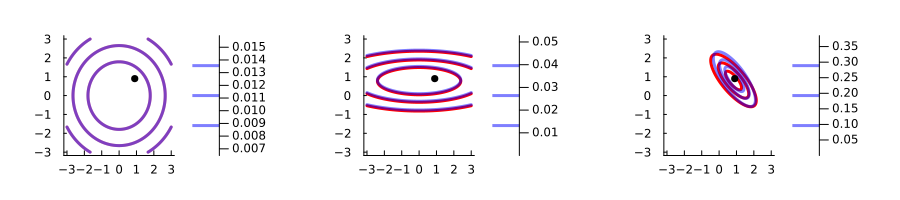

┌ Warning: Multiple series with different line alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different line alpha share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with differen

In [36]:
xr1 = range(-3, stop=3, length=100)
xr2 = range(-3, stop=3, length=100)

kix = 2
p441 = contour(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_MSE[kix][2:end], inv(Λ_MSE[kix][2:end,2:end])), [xr1,xr2]), color="red", alpha=0.5, levels=3)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", alpha=0.5, levels=3)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

kix = 3
p442 = contour(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_MSE[kix][2:end], inv(Λ_MSE[kix][2:end,2:end])), [xr1,xr2]), color="red", levels=3)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", alpha=0.5, levels=3)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

kix = 5
p443 = contour(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_MSE[kix][2:end], inv(Λ_MSE[kix][2:end,2:end])), [xr1,xr2]), color="red", levels=3)
contour!(xr1, xr2, (xr1,xr2) -> Distributions.pdf(MvNormal(μ_EFE[kix][2:end], inv(Λ_EFE[kix][2:end,2:end])), [xr1,xr2]), color="blue", alpha=0.5, levels=3)
scatter!([sys_coefficients[2]], [sys_coefficients[3]], color="black")

plot(p441, p442, p443, layout=(1,3), size=(900,200))

### Comparison

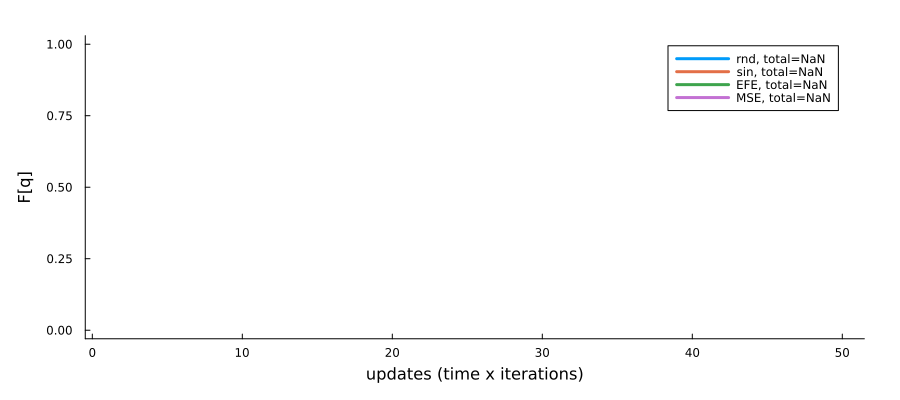

In [57]:
sF_rnd = round(sum(FE_rnd[:]), digits=2)
sF_sin = round(sum(FE_sin[:]), digits=2)
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_rnd[:], label="rnd, total=$sF_rnd")
plot!(FE_sin[:], label="sin, total=$sF_sin")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")


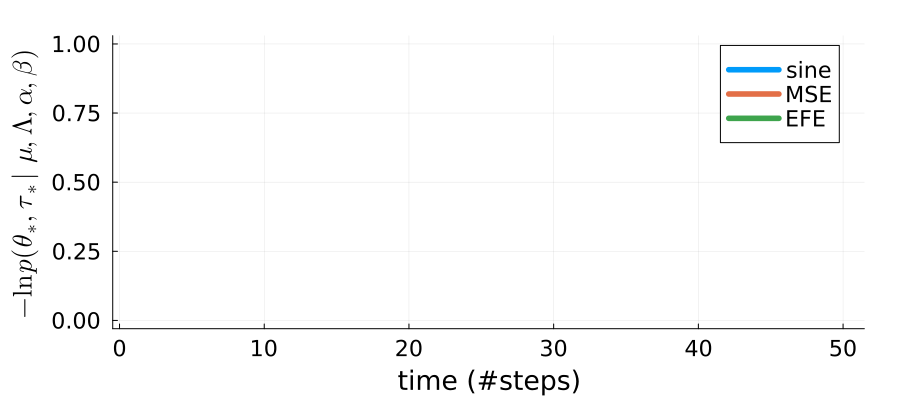

In [56]:
idθ_rnd = [-mv_normal_gamma.logpdf(MvNormalGamma(μ_rnd[k], Λ_rnd[k], α_rnd[k], β_rnd[k]), sys_coefficients, inv(sys_mnoise_sd^2)) for k in 1:N]
idθ_sin = [-mv_normal_gamma.logpdf(MvNormalGamma(μ_sin[k], Λ_sin[k], α_sin[k], β_sin[k]), sys_coefficients, inv(sys_mnoise_sd^2)) for k in 1:N]
idθ_MSE = [-mv_normal_gamma.logpdf(MvNormalGamma(μ_MSE[k], Λ_MSE[k], α_MSE[k], β_MSE[k]), sys_coefficients, inv(sys_mnoise_sd^2)) for k in 1:N]
idθ_EFE = [-mv_normal_gamma.logpdf(MvNormalGamma(μ_EFE[k], Λ_EFE[k], α_EFE[k], β_EFE[k]), sys_coefficients, inv(sys_mnoise_sd^2)) for k in 1:N]

plot(xlabel="time (#steps)", grid=true, guidefontsize=18, tickfontsize=15, legendfontsize=15, ylabel=L"$-\ln p(θ_{*}, \tau_{*} \, | \, μ, Λ, \alpha, \beta)$", size=(900,400), legend=:topright)
# plot!(idθ_rnd, label="rnd")
plot!(idθ_sin, label="sine")
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

In [39]:
savefig("figures/posttrue-comparison.png")

┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/learningrates/figures/posttrue-comparison.png"

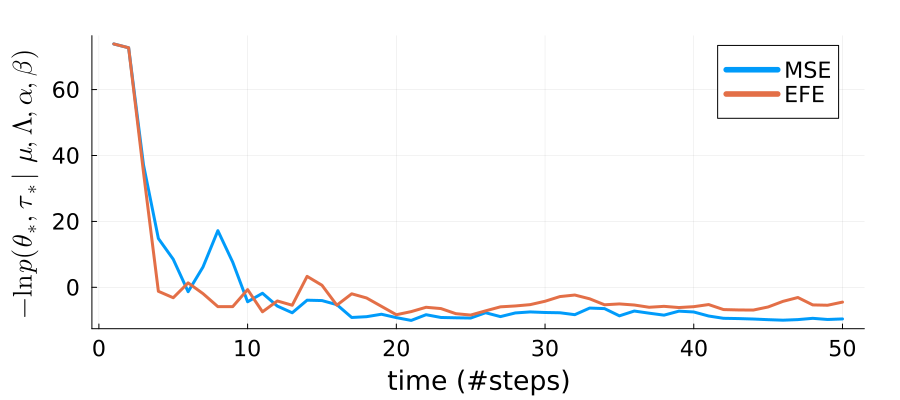

In [54]:
idθ_rnd = [-location_scale_tdist.logpdf(MvLocationScaleT(2α_rnd[k], μ_rnd[k], inv(α_rnd[k]./β_rnd[k]*Λ_rnd[k])), sys_coefficients) for k in 1:N]
idθ_sin = [-location_scale_tdist.logpdf(MvLocationScaleT(2α_sin[k], μ_sin[k], inv(α_sin[k]./β_sin[k]*Λ_sin[k])), sys_coefficients) for k in 1:N]
idθ_MSE = [-location_scale_tdist.logpdf(MvLocationScaleT(2α_MSE[k], μ_MSE[k], inv(α_MSE[k]./β_MSE[k]*Λ_MSE[k])), sys_coefficients) for k in 1:N]
idθ_EFE = [-location_scale_tdist.logpdf(MvLocationScaleT(2α_EFE[k], μ_EFE[k], inv(α_EFE[k]./β_EFE[k]*Λ_EFE[k])), sys_coefficients) for k in 1:N]

plot(xlabel="time (#steps)", grid=true, guidefontsize=18, tickfontsize=15, legendfontsize=15, ylabel=L"$-\ln p(θ_{*}, \tau_{*} \, | \, μ, Λ, \alpha, \beta)$", size=(900,400), legend=:topright)
# plot!(idθ_rnd, label="rnd")
# plot!(idθ_sin, label="sine")
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")